# PTEN loss Survival Analysis for GBM

Imports

In [ ]:
import pandas as pd
import cptac
import cptac.utils as ut
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import lifelines
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
from lifelines.statistics import proportional_hazard_test
%matplotlib inline

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
'''
Params
cancer_object: Object. The loaded cancer data set.
all_prot: List. trans proteins used to get proteomics data. 
gene_in: String. Gene used to get mutation status for the Mutation col.
utils: utils package from cptac.  

Returns a dataframe with trans proteomics and mutation status of a specific gene.
'''

def all_prot_format_df(cancer_object, all_prot, gene_in = 'PTEN', utils = ut):
    mut_type = cancer_object.get_genotype_all_vars(gene_in)
    
    if cancer_object.get_cancer_type() not in ('luad', 'endometrial'):
        # Keep only tumor samples from proteomics
        prot_and_mutations = cancer_object.join_omics_to_mutations(
            mutations_genes = [gene_in], omics_df_name = 'proteomics', omics_genes = all_prot, tissue_type = 'tumor')
        # Reduce a multiindex 
        if isinstance(prot_and_mutations.keys(), pd.core.indexes.multi.MultiIndex):
            prot_and_mutations = utils.reduce_multiindex(prot_and_mutations, levels_to_drop = 1)
            prot_and_mutations = rename_duplicate_cols(prot_and_mutations)
        
        # Merge Mutation column from get_genotype_all_vars (includes cnv) with proteomics
        mut_type = mut_type[['Mutation']] 
        prot_df = prot_and_mutations.iloc[:,:-4] # Keep only proteomics
        merged = prot_df.join(mut_type)
        
        # Keep only Wildtype and deletion
        compare = ['Wildtype_Tumor','Deletion']
        get = merged['Mutation'].isin(compare)
        mut_wt = merged[get]
    
    
    # Luad has no somatic mutations for PTEN which changes some things
    elif cancer_object.get_cancer_type() in ('luad'): 
        # get_genotype_all_vars add cnv data under the column PTEN
        mut_type = mut_type.drop(columns= gene_in)
        # different code because no somatic mutation data for pten (can't join to somatic mutations)
        omics = cancer_object.join_omics_to_omics(df1_name = 'CNV', df2_name='proteomics',genes1= gene_in, 
            genes2= all_prot, tissue_type = 'tumor')
        omics = utils.reduce_multiindex(omics, levels_to_drop = 1, flatten = True)
        omics = rename_duplicate_cols(omics)
        omics = omics.drop(columns='PTEN_CNV')
       
        # Merge Mutation column from get_genotype_all_vars (includes cnv) with proteomics
        merged = omics.join(mut_type) 
        # Keep only No_Mutation (wildtype) and deletion
        compare = ['No_Mutation','Deletion']
        get = merged['Mutation'].isin(compare)
        mut_wt = merged[get]
        mut_wt['Mutation'] = np.where(
            mut_wt['Mutation'] == 'No_Mutation', 'Wildtype_Tumor', 'Deletion')
        
    elif cancer_object.get_cancer_type() in ('endometrial'):
        # merge cnv with genotype all mut type
        prot_and_mutations = cancer_object.join_omics_to_mutations(
            mutations_genes = [gene_in], omics_df_name = 'proteomics', omics_genes = all_prot, tissue_type = 'tumor') # drop Normal samples

        prot_df = prot_and_mutations.iloc[:,:-4] #drop Mutation and Location cols
        mut_type = mut_type[['Mutation']] # Get Mutation col that includes CNV
        merged = prot_df.join(mut_type) # merge 

        # Create Truncation category and keep truncation and wt
        compare = ['Wildtype_Tumor','Nonsense_Mutation','Frame_Shift_Ins','Frame_Shift_Del']
        get = merged['Mutation'].isin(compare)
        mut_wt = merged[get]
        mut_wt['Mutation'] = np.where(
                        mut_wt['Mutation'] == 'Wildtype_Tumor', 'Wildtype_Tumor', 'Truncation')
    
    mut_wt = mut_wt.rename(columns={col: re.sub(r'_proteomics', '', col) for col in mut_wt.columns.tolist()})
    return mut_wt


In [ ]:
''' Adds '_i' to duplicate col names where the int i increases by one with each duplicate 
Returns a df with unique column names. '''

def rename_duplicate_cols(df):
    cols = pd.Series(df.columns[:])

    for dup in cols[cols.duplicated()].unique(): 
        cols[cols[cols == dup].index.values.tolist()] = [dup + '_' + str(i) if i != 0 else dup for i in range(sum(cols == dup))]

    # rename the columns with the cols list.
    df.columns=cols
    return df

In [ ]:
def get_survival_cols(cancer_object):
    cancer = cancer_object.get_cancer_type()
    #print(cancer)
    
    # get unique survival col names
    if cancer == 'gbm':
        cols = ['vital_status', 'path_diag_to_last_contact_days', 'path_diag_to_death_days']
    if cancer == 'hnscc':
        cols = ['VITAL_STATUS', 'PATHO_DIAG_TO_LAST_CONT_DAYS', 'PATHO_DIAG_TO_DEATH_DAYS']
    if cancer == 'luad':
        cols = ['Vital Status', 'Path Diag to Last Contact(Day)', 'Path Diag to Death(days)']
    if cancer == 'ovarian':
        cols = ['Vital_Status', 'Days_Between_Collection_And_Last_Contact', 'Days_Between_Collection_And_Death']
    if cancer == 'endometrial':
        cols = ['Vital Status', 'Path Diag to Last Contact(Day)', 'Path Diag to Death(days)']
    
    # lscc no follow up or clin matching survival cols

    if cancer == 'brca':
        cols = ['Vital Status (at time of last contact)'] 
        print('Use csv')
    if cancer == 'colon':
        cols = ['Vital Status (at time of last contact)'] 
        print('Use csv')

    return cols

# Step 1: Import data

In [ ]:
cancer = 'GBM'
g = cptac.Gbm()

# Step 2: Get df with PTEN mutation status and clinical data

In [ ]:
cols = get_survival_cols(g) # get 'vital_status', 'days_to_last_contact', 'days_to_death'
followup = ca.get_followup()
df = followup[cols]
df

In [82]:
del_wt = all_prot_format_df(g, ['PTEN']) # get Mutation col (PTEN del/wt)
mut_survival = del_wt.join(df, on = 'Patient_ID', how = 'left') # combine keeping only turmors
mut_survival

Name,PTEN,Mutation,vital_status,days_to_last_contact,days_to_death
Patient_ID,,,,,
C3L-00104,-0.431991,Deletion,Deceased,128.0,129.0
C3L-00365,-0.265044,Deletion,Deceased,280.0,322.0
C3L-00674,0.390190,Deletion,Deceased,385.0,478.0
C3L-00677,-0.915526,Deletion,Deceased,154.0,154.0
C3L-01040,0.680291,Deletion,Living,608.0,NaN
...,...,...,...,...,...
C3N-03183,-0.725120,Deletion,Deceased,314.0,314.0
C3N-03184,-0.242603,Deletion,NaN,NaN,NaN
C3N-03186,0.428594,Deletion,Living,459.0,NaN


# Step 3: Kaplan Meier Plotting

Kaplan Meier plots show the probability of some event occuring over a given length of time, based on some attribute(s). 

In [66]:
print(mut_survival.vital_status.value_counts(), '\n')
del_df = mut_survival.loc[mut_survival['Mutation'] == 'Deletion']
print('del:\n', del_df.vital_status.value_counts(), '\n')
wt_df = mut_survival.loc[mut_survival['Mutation'] == 'Wildtype_Tumor']
print('wt:\n', wt_df.vital_status.value_counts())

Deceased    47
Living      44
Name: vital_status, dtype: int64 

del:
 Deceased    40
Living      37
Name: vital_status, dtype: int64 

wt:
 Living      7
Deceased    7
Name: vital_status, dtype: int64


In [67]:
#Then we will drop missing values, as missing values 
#will throw an error in the functions we will use in lifelines.
mut_survival['vital_status'] = mut_survival['vital_status'].dropna(axis= 'index', how='any')
len(mut_survival)

97

In [81]:
#Make the vital_status column boolean
mut_survival['vital_status'] = mut_survival['vital_status'].replace('Living', False) # dead is true
print(mut_survival['vital_status'].unique())
#mut_survival['vital_status'] = mut_survival['vital_status'].replace('Deceased', True)
print(len(mut_survival))
mut_survival.dropna(axis = 'index', how = 'any', inplace = True) # drop nan in vital_status before change to bool (or else counts differ)
print(len(mut_survival))
#mut_survival['vital_status'] = mut_survival['vital_status'].astype('bool')

# Create one column with days between last contact or death
days = ['days_to_last_contact', 'days_to_death']
df_genes = mut_survival.assign(days_to_last_contact_or_death = mut_survival[days].sum(1)).drop(days, 1)
df_genes.vital_status.value_counts()
mut_survival['vital_status'].dropna()

[True False nan]
97
47


Patient_ID
C3L-00104    True
C3L-00365    True
C3L-00674    True
C3L-00677    True
C3L-01043    True
C3L-01045    True
C3L-01046    True
C3L-01049    True
C3L-01156    True
C3L-01327    True
C3L-01834    True
C3L-02465    True
C3L-02542    True
C3L-02705    True
C3L-02955    True
C3L-03266    True
C3L-03392    True
C3L-03405    True
C3L-03407    True
C3L-03681    True
C3L-03728    True
C3L-04084    True
C3N-00662    True
C3N-00663    True
C3N-01196    True
C3N-01334    True
C3N-01366    True
C3N-01368    True
C3N-01505    True
C3N-01515    True
C3N-01518    True
C3N-01798    True
C3N-01815    True
C3N-01816    True
C3N-01818    True
C3N-01851    True
C3N-01856    True
C3N-01857    True
C3N-02183    True
C3N-02188    True
C3N-02190    True
C3N-02255    True
C3N-02256    True
C3N-02770    True
C3N-02785    True
C3N-03088    True
C3N-03183    True
Name: vital_status, dtype: object

In [69]:
# Plot
time = df_genes['days_to_last_contact_or_death']
status = df_genes['vital_status']

kmf = KaplanMeierFitter()
kmf.fit(time, event_observed = status)
kmf.plot()

TypeError: NaNs were detected in the dataset. Try using pd.isnull to find the problematic values.

# Step 4: Prepare Data for Multivariate Kaplan Meier Plots and Cox's Proportional Hazard Test

In [24]:
# map numeric values to correspond with mutation status
mutation_map = {"Wildtype_Tumor" : 0, "Deletion" : 1}

df_genes['PTEN'] = df_genes['Mutation'].map(mutation_map)

#Then we will drop missing values, as missing values 
#will throw an error in the functions we will use in lifelines.
df_clean = df_genes.dropna(axis=0, how='any').copy()
df_clean = df_clean.drop(columns= 'Mutation') # drop col with str values (info mapped to PTEN as int)
df_clean

Name,PTEN,vital_status,days_to_last_contact_or_death
Patient_ID,,,
C3L-00104,1,True,257.0
C3L-00365,1,True,602.0
C3L-00674,1,True,863.0
C3L-00677,1,True,308.0
C3L-01040,1,False,608.0
...,...,...,...
C3N-03183,1,True,628.0
C3N-03184,1,True,0.0
C3N-03186,1,False,459.0


Verify that your columns are the correct data types.  The event of interest, in this case Vital_Status needs to contain boolean values, and all other columns in the table must be of a numeric type (either int64 or float64).

In [25]:
for col in df_clean.columns:
    print(col, ":", df_clean[col].dtype)

PTEN : int64
vital_status : bool
days_to_last_contact_or_death : float64


# Step 5: Plot Multivariate Survival Risk

1 is wt. 2 is mutant.

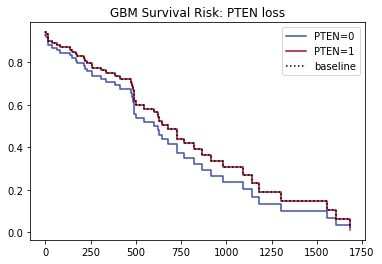

In [26]:
cph = CoxPHFitter()
cph.fit(df_clean, duration_col = "days_to_last_contact_or_death", 
        event_col = "vital_status")

plot_title = cancer+" Survival Risk: PTEN loss"
cph.plot_partial_effects_on_outcome('PTEN', [0,1], cmap='coolwarm', title=plot_title)
    

In [13]:
cph.print_summary(model="untransformed variables", decimals=3)


<lifelines.CoxPHFitter: fitted with 97 total observations, 44 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'vital_status'
      baseline estimation = breslow
   number of observations = 97
number of events observed = 53
   partial log-likelihood = -185.904
         time fit was run = 2020-11-02 15:37:58 UTC
                    model = untransformed variables

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
PTEN      -0.192      0.825      0.372           -0.921            0.537                0.398                1.711

               z     p   -log2(p)
covariate                        
PTEN      -0.516 0.606      0.723
---
Concordance = 0.518
Partial AIC = 373.809
log-likelihood ratio test = 0.256 on 1 df
-log2(p) of ll-ratio test = 0.706

# Step 6: Cox's Proportional Hazard Test

With the proportional_hazard_test function, we can now perform Cox's Proportional Hazard Test on the data to determine how each attribute contributes to our cohort's overall survival. This is shown by the hazard ratio in the column labeled -log2(p) below. In general, a hazard ratio of 1 suggests that an attribute has no effect on overall survival. A ratio less than 1 suggests that an attribute contributes to lower risk. A ratio greater than 1 suggests that an attribute contributes to higher risk.

In [14]:
results = proportional_hazard_test(cph, df_clean, time_transform='rank')
results.print_summary(decimals=3, model="untransformed variables")

<lifelines.StatisticalResult: proportional_hazard_test>
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 97 total observations, 44 right-censored observations>
         test_name = proportional_hazard_test

---
      test_statistic    p  -log2(p)
PTEN            0.05 0.82      0.28

Below, we show the confidence interval for the hazard ratio. 

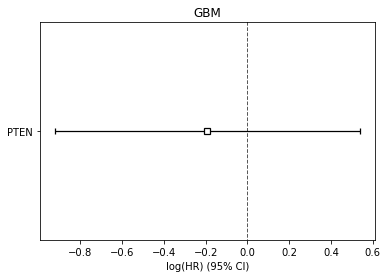

In [15]:
plt.title(cancer)
cph.plot()

In [16]:
# log(hazards ratio) = coef = -0.192

Conclusions: Because the p-value was greater than 0.05, there is insufficient evidence to suggest that PTEN loss effects survival risk.